In [1]:
import os
import gc
import warnings

import pandas as pd
import numpy as np

warnings.filterwarnings(action = 'ignore')

In [2]:
train_transaction = pd.read_csv("../dataset/train_transaction.csv")
train_identity = pd.read_csv("../dataset/train_identity.csv")

test_transaction = pd.read_csv("../dataset/test_transaction.csv")
test_identity = pd.read_csv("../dataset/test_identity.csv")

In [3]:
train_df = pd.merge(left = train_transaction,right=train_identity,how='left', on = 'TransactionID').reset_index()

In [4]:
del train_identity, train_transaction
gc.collect()

42

In [25]:
%run DataPrepare.ipynb

In [7]:
Reduce_Memory_Usage(train_df)

origin memory usage: 1959.8763732910156
reduced memory usage: 648.223560333252
memory reduce (66.9%)


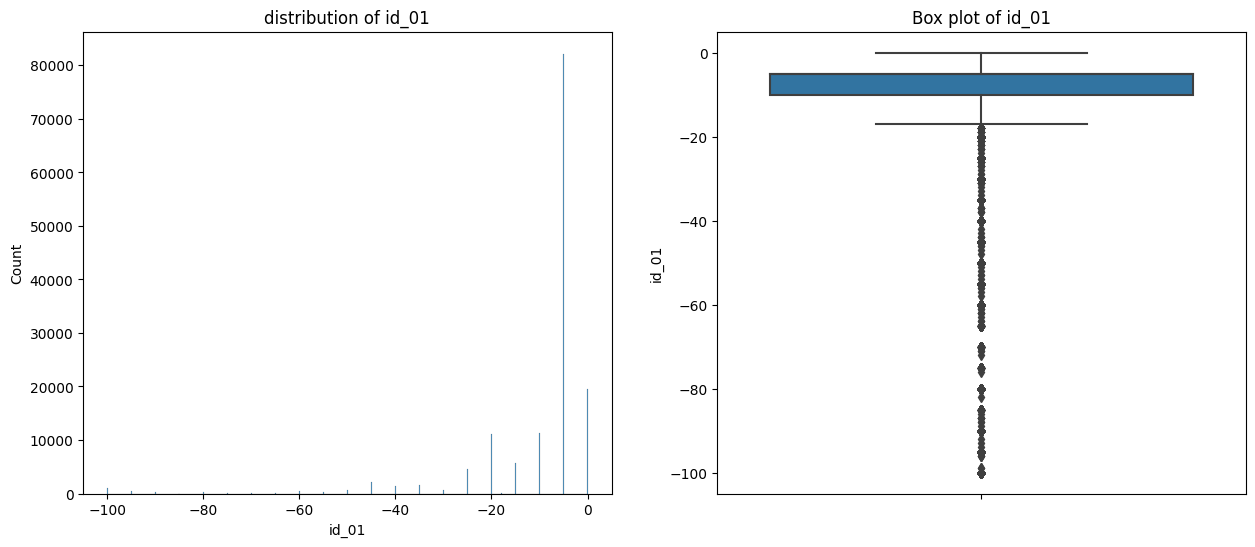


1.IQR method:
the num over Q3+1.5IQR is:0
the num below Q1-1.5IQR is:25480

2.mean_std method:
the num over 3std is:0
the num below 3std is:0

3.value counts of id_01
 NaN     0.755761
-5.0     0.139144
 0.0     0.033114
-10.0    0.019062
-20.0    0.018984
           ...   
-89.0    0.000002
-93.0    0.000002
-24.0    0.000002
-94.0    0.000002
-51.0    0.000002
Name: id_01, Length: 78, dtype: float64

4.value counts of id_01
count    144233.0
mean          NaN
std           0.0
min        -100.0
25%         -10.0
50%          -5.0
75%          -5.0
max           0.0
Name: id_01, dtype: float64


In [26]:
Plot_Num_Feature(train_df,col = 'id_01')
Value_Count_Description(train_df,'id_01')

id_01 不是正太分布

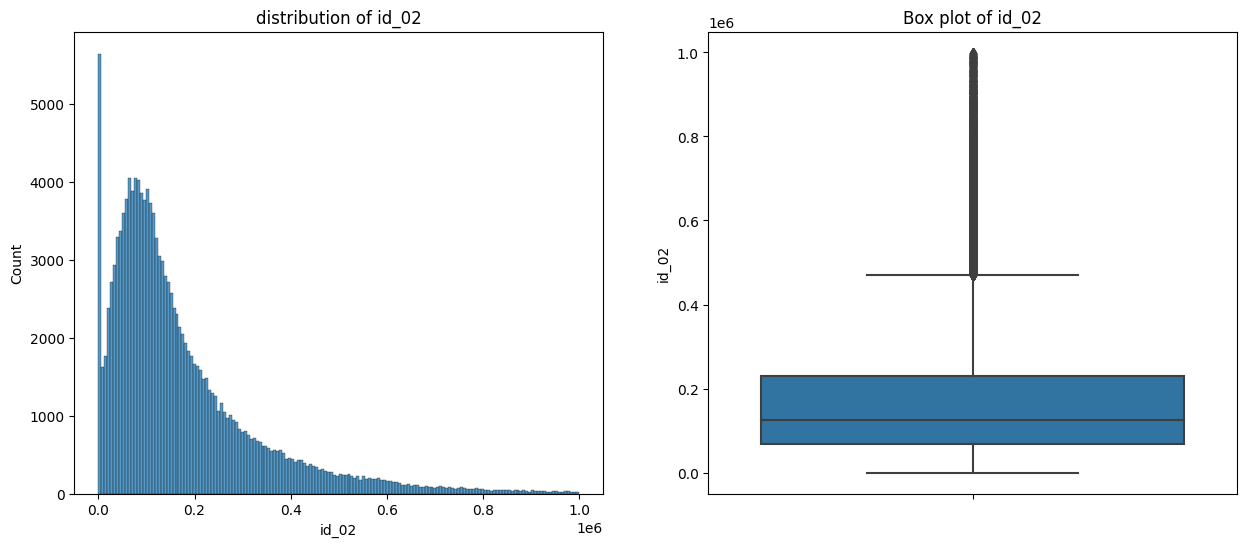


1.IQR method:
the num over Q3+1.5IQR is:8770
the num below Q1-1.5IQR is:0

2.mean_std method:
the num over 3std is:2981
the num below 3std is:0

3.value counts of id_02
NaN         0.761452
1102.0      0.000019
696.0       0.000017
1116.0      0.000015
1120.0      0.000015
              ...   
11447.0     0.000002
37550.0     0.000002
24801.0     0.000002
247735.0    0.000002
55528.0     0.000002
Name: id_02, Length: 115656, dtype: float64

4.value counts of id_02
count    140872.00000
mean     174716.59375
std      159651.81250
min           1.00000
25%       67992.00000
50%      125800.50000
75%      228749.00000
max      999595.00000
Name: id_02, dtype: float64


In [27]:
Plot_Num_Feature(train_df,col = 'id_02')
Value_Count_Description(train_df,'id_02')

id_02 基本是偏态分布，缺失值较多，可以考虑采用统计方法填充

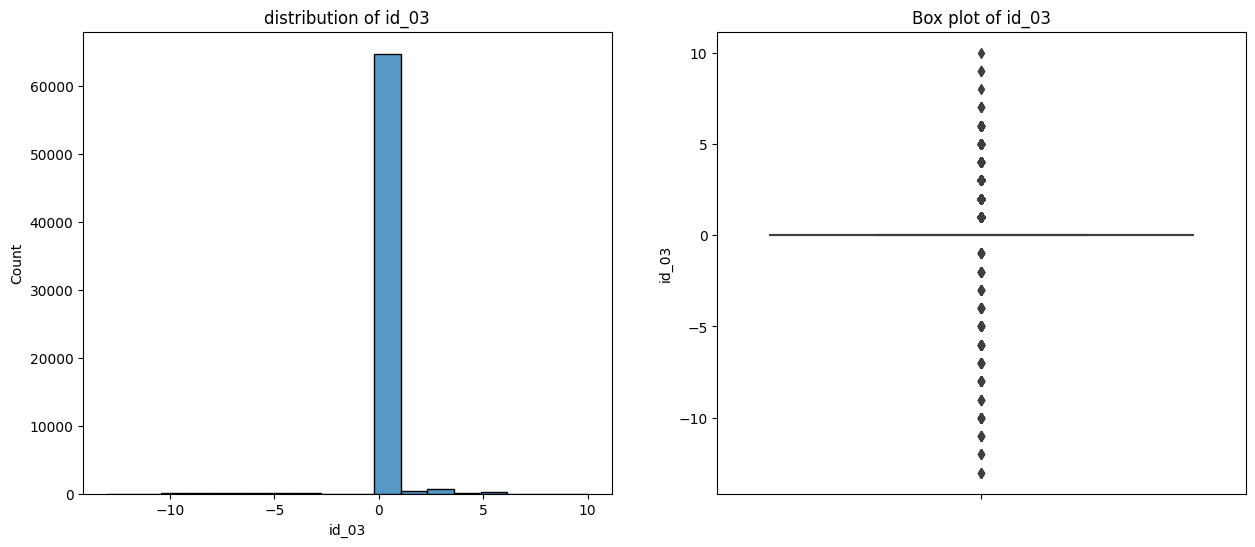


1.IQR method:
the num over Q3+1.5IQR is:2234
the num below Q1-1.5IQR is:187

2.mean_std method:
the num over 3std is:2234
the num below 3std is:187

3.value counts of id_03
 NaN     0.887689
 0.0     0.108211
 1.0     0.001461
 3.0     0.001131
 2.0     0.000713
 5.0     0.000185
 4.0     0.000169
 6.0     0.000108
-5.0     0.000056
-6.0     0.000052
-7.0     0.000036
-4.0     0.000036
-10.0    0.000029
-8.0     0.000024
-2.0     0.000020
-1.0     0.000020
-3.0     0.000014
-9.0     0.000010
-11.0    0.000010
 7.0     0.000007
 9.0     0.000005
-12.0    0.000005
-13.0    0.000005
 10.0    0.000002
 8.0     0.000002
Name: id_03, dtype: float64

4.value counts of id_03
count    66324.0
mean         0.0
std          0.0
min        -13.0
25%          0.0
50%          0.0
75%          0.0
max         10.0
Name: id_03, dtype: float64


In [28]:
Plot_Num_Feature(train_df,col = 'id_03')
Value_Count_Description(train_df,'id_03')

id_03 且取值较为单一，缺失值较多

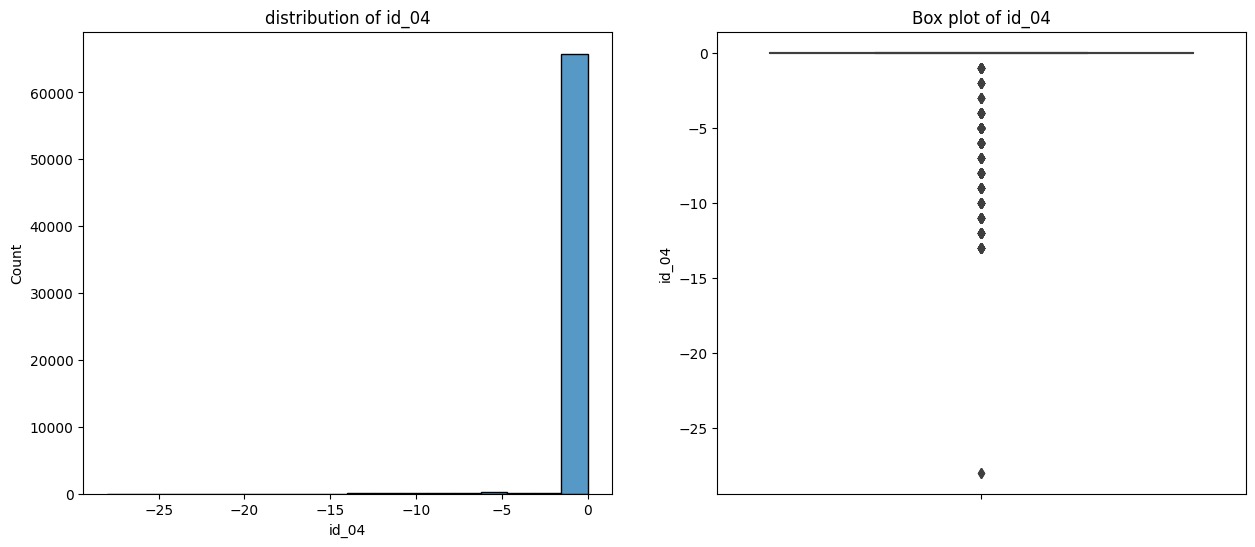


1.IQR method:
the num over Q3+1.5IQR is:0
the num below Q1-1.5IQR is:585

2.mean_std method:
the num over 3std is:0
the num below 3std is:585

3.value counts of id_04
 NaN     0.887689
 0.0     0.111320
-5.0     0.000224
-6.0     0.000166
-8.0     0.000108
-4.0     0.000086
-1.0     0.000073
-11.0    0.000059
-12.0    0.000058
-10.0    0.000051
-9.0     0.000044
-13.0    0.000041
-7.0     0.000036
-2.0     0.000025
-3.0     0.000017
-28.0    0.000003
Name: id_04, dtype: float64

4.value counts of id_04
count    66324.0
mean        -0.0
std          0.0
min        -28.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: id_04, dtype: float64


In [31]:
Plot_Num_Feature(train_df, col ='id_04')
Value_Count_Description(train_df, col = 'id_04')


1.IQR method:
the num over Q3+1.5IQR is:0
the num below Q1-1.5IQR is:585

2.mean_std method:
the num over 3std is:0
the num below 3std is:585

3.value counts of id_04
 NaN     0.887689
 0.0     0.111320
-5.0     0.000224
-6.0     0.000166
-8.0     0.000108
-4.0     0.000086
-1.0     0.000073
-11.0    0.000059
-12.0    0.000058
-10.0    0.000051
-9.0     0.000044
-13.0    0.000041
-7.0     0.000036
-2.0     0.000025
-3.0     0.000017
-28.0    0.000003
Name: id_04, dtype: float64

4.value counts of id_04
count    66324.0
mean        -0.0
std          0.0
min        -28.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: id_04, dtype: float64
